In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
import numpy as np
import torchvision
import random

from itertools import chain

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Доп.Ф-ции

In [ ]:
class Vocab:
    def __init__(self, data:list, start=0, num_words=5000): # data - list of tokens
        self.create_count_dict(data)
        self.token_to_count = dict(sorted(self.token_to_count.items(), key = lambda x: x[1], reverse=True)[0:num_words])

        self.idx_to_token = {i+start: v for i,v in enumerate(self.token_to_count.keys())}
        self.token_to_idx = {v: i+start for i,v in enumerate(self.token_to_count.keys())}
        self.vocab_len = len(self.token_to_count.keys())


    def create_count_dict(self, data):
        self.token_to_count = {}
        for token in data:
            if token not in self.token_to_count.keys():
                self.token_to_count[token] = 1
            else:
                self.token_to_count[token] += 1

    def __len__(self):
        return self.vocab_len

In [ ]:
def create_uni_vec(vocab, sent): # sent: list, list of tokens
    new_seq = torch.stack([torch.tensor([1 if token == sample else 0 for token in vocab.token_to_count.keys()]) for sample in sent])
    return new_seq

def create_idx_vec(vocab, sent): #sent: list, list of tokens
    new_seq = torch.tensor([vocab.token_to_idx[item] for item in sent])
    return new_seq

In [ ]:
class EarlyStopping():
  def __init__(self, min_delta=0.001, tolerance=20):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.flag = False
    self.min_loss = 1000

  def __call__(self, val_loss):
    if (val_loss - self.min_loss) > self.min_delta:
      self.counter += 1
      print(f'counter = {self.counter}')
      if self.counter >= self.tolerance:
        self.flag = True
    self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

In [ ]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_batch, local_label) in train_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_batch, local_label) in val_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    _, preds = torch.max(y_pred, 1)
    test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(local_label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

## 1. Представление и предобработка текстовых данных в виде последовательностей

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
tokens = list(nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", text)))
sent = nltk.sent_tokenize(text)
sent = nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", sent[0]))
voc1 = Vocab(tokens)

In [ ]:
print(create_idx_vec(voc1, sent))

tensor([2, 3, 4, 0, 5, 1, 6, 7])


1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
tokens = list(nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", text)))
sent = nltk.sent_tokenize(text)
sent = nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", sent[0]))
voc1 = Vocab(tokens)

In [ ]:
for x in create_uni_vec(voc1, sent):
    print(x)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
tokens = list(nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", text)))
sent = nltk.sent_tokenize(text)
sent = nltk.word_tokenize(re.sub(r"[^a-zA-Z]", " ", sent[0]))
voc1 = Vocab(tokens)
emb = nn.Embedding(len(voc1), 1, max_norm=1)

In [ ]:
with torch.no_grad():
    emb.weight[:] = 0
    emb.weight[1] = 1

In [ ]:
x = create_uni_vec(voc1, sent)
for i in emb(x).squeeze(-1):
    print(i)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], grad_fn=<UnbindBack

## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта:
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

### data structures

In [ ]:
class Vocab:
    def __init__(self, data:list, spec_symb=True, start=0): # data - list of tokens
        self.create_tokens_set(data)

        self.idx_to_token = {i+start: v for i,v in enumerate(self.tokens)}

        self.token_to_idx = {v: i+start for i,v in enumerate(self.tokens)}

        if spec_symb and start>0:
            self.idx_to_token[0] = '<PAD>'
            self.token_to_idx['<PAD>'] = 0

    def create_tokens_set(self, data):
        self.tokens = list(set(data))

    def __len__(self):
        return len(self.token_to_idx)

In [ ]:
class SurnamesDataset(torch.utils.data.Dataset):
    def __init__(self, path, uni_vec=False):
        self.load_df(path)
        self.preprocess_df()
        self.sur_vocab = Vocab(list(chain.from_iterable([[x for x in word] for word in self.df['surname'].tolist()])), spec_symb=True, start=1)
        self.nat_vocab = Vocab(self.df['nationality'].tolist(), spec_symb=False, start=0)

        self.df['len'] = self.df.surname.map(len)
        self.max_seq_len = self.df['len'].max()

        self.X = self.df['surname'].tolist()
        self.y = self.df['nationality'].tolist()
        self.uni_vec = uni_vec

    def pad_features(self, target, max_len):
        diff = max_len - len(target)
        for i in range(diff):
            target.append(0)
        return torch.tensor(target)


    def preprocess_df(self):
        self.df['surname'] = self.df['surname'].str.lower()
        self.df['nationality'] = self.df['nationality'].str.lower()

    def load_df(self, path):
        self.df = pd.read_csv(path)

    def create_idx_vec(self, sent): #sent: list, list of tokens
        new_seq = [self.sur_vocab.token_to_idx[item] for item in sent]
        return new_seq

    def create_uni_vec(self, sent):
        new_seq = torch.stack([torch.tensor([1 if token == sample else 0 for token in self.sur_vocab.idx_to_token.keys()]) for sample in sent])
        return new_seq

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.uni_vec:
            return self.create_uni_vec(self.pad_features(self.create_idx_vec(self.X[idx]), self.max_seq_len).tolist()), self.nat_vocab.token_to_idx[self.y[idx]]
        return self.pad_features(self.create_idx_vec(self.X[idx]), self.max_seq_len), self.nat_vocab.token_to_idx[self.y[idx]]

In [ ]:
class GetFeaturesFromRNN(torch.nn.Module):
    def forward(self, x):
        x, _ = x
        if len(x.shape) == 3:
            return x[:, -1, :]
        elif len(x.shape) == 2:
            return x[:, -1]

In [ ]:
class Transpose(torch.nn.Module):
    def __init__(self, dim0, dim1):
        super(Transpose, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        x = torch.transpose(x, self.dim0, self.dim1)
        return x

In [ ]:
class Model_2(torch.nn.Module):
    def __init__(self, input_size, output_size): #input_size - len of rev dict
        super(Model_2, self).__init__()
        self.features = nn.Sequential(
            nn.Embedding(input_size, embedding_dim=20, padding_idx=0),
            nn.Dropout(0.25),
            Transpose(dim0=1, dim1=2),
            nn.Conv1d(in_channels=20, out_channels=50, kernel_size=3, stride=1, padding=0, dilation=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(2),
            Transpose(dim0=1, dim1=2),
            nn.LSTM(50, 200, num_layers=3, batch_first=True, dropout=0.5),
            GetFeaturesFromRNN()
        )
        self.classificator = nn.Sequential(
            nn.Linear(in_features=200, out_features=output_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.features.forward(x)
        x = torch.flatten(x, 1)
        x = self.classificator.forward(x)
        return x

In [ ]:
class sshape(torch.nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [ ]:
class ssqueze(torch.nn.Module):
    def forward(self, x):
        return x.squeeze(-1)

In [ ]:
class Model_1(torch.nn.Module):
    def __init__(self, input_size, output_size): #input_size - len of rev dict
        super(Model_1, self).__init__()
        self.features = nn.Sequential(
            nn.Embedding(input_size, embedding_dim=1, padding_idx=0),
            ssqueze(),
            nn.Dropout(0.25),
            Transpose(dim0=1, dim1=2),
            nn.Conv1d(in_channels=input_size, out_channels=50, kernel_size=3, stride=1, padding=0, dilation=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(2),
            Transpose(dim0=1, dim1=2),
            nn.LSTM(50, 200, num_layers=3, batch_first=True, dropout=0.5),
            GetFeaturesFromRNN()
        )

        with torch.no_grad():
            self.features[0].weight[:] = 0
            self.features[0].weight[1] = 1

        self.classificator = nn.Sequential(
            nn.Linear(in_features=200, out_features=output_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.features.forward(x)
        x = torch.flatten(x, 1)
        x = self.classificator.forward(x)
        return x

### code proccessing

#### model_1

In [ ]:
path = 'C:\\Users\\user\\Desktop\\dz\\DL\\lab5\\data\\surnames.csv'

In [ ]:
dataset = SurnamesDataset(path, uni_vec=True)

In [ ]:
BATCH_SIZE = 100
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [ ]:
in_size = len(dataset.sur_vocab)
out_size = len(dataset.nat_vocab)
print(f'in = {in_size}, out = {out_size}')

in = 56, out = 18


In [ ]:
model = Model_1(in_size, out_size).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 856924


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
for param in model.features[0].parameters():
    param.requires_grad = False

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.005, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
for epoch in range(EPOCH):
    print(f'epoch = {epoch}, ', end="")
    epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
    train_loss.append(epoch_train_loss)

    with torch.no_grad():
        epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
        val_loss.append(epoch_val_loss)

    early_stopping(epoch_val_loss)
    if early_stopping.flag:
        print(f'early stop at epoch №{epoch}')
        break
torch.cuda.empty_cache() if device == 'cuda' else None

epoch = 0, 

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch = 1, epoch = 2, epoch = 3, epoch = 4, epoch = 5, epoch = 6, epoch = 7, counter = 1
epoch = 8, epoch = 9, epoch = 10, epoch = 11, epoch = 12, epoch = 13, epoch = 14, counter = 2
epoch = 15, counter = 3
epoch = 16, epoch = 17, epoch = 18, epoch = 19, epoch = 20, epoch = 21, epoch = 22, epoch = 23, epoch = 24, epoch = 25, counter = 4
epoch = 26, counter = 5
epoch = 27, counter = 6
epoch = 28, counter = 7
epoch = 29, epoch = 30, counter = 8
epoch = 31, epoch = 32, epoch = 33, epoch = 34, epoch = 35, epoch = 36, counter = 9
epoch = 37, counter = 10
early stop at epoch №37


<Axes: >

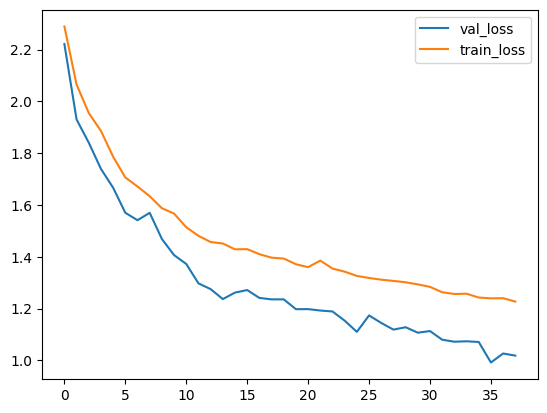

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataset.nat_vocab)
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 71.22%


<Axes: >

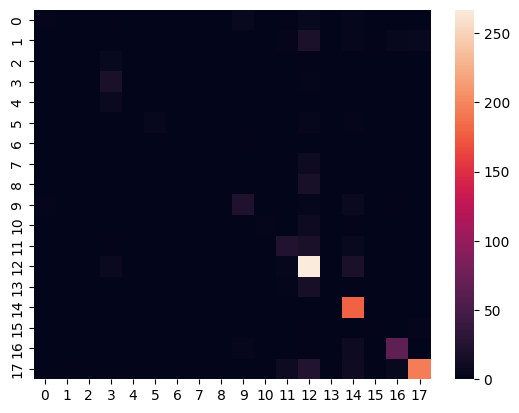

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

In [ ]:
students = ['Alueva', 'Sultonov', 'Mikhailenko']
students = [dataset.create_uni_vec(dataset.pad_features(dataset.create_idx_vec(x.lower()), dataset.max_seq_len).tolist()) for x in students]
students = torch.stack(students).to(device)

preds = model.forward(students)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
_, preds = torch.topk(preds, 3)
preds

tensor([[ 0,  8,  1],
        [17,  1,  9],
        [17,  1, 16]], device='cuda:0')

In [ ]:
nat_list = [[dataset.nat_vocab.idx_to_token[z] for z in x] for x in preds.cpu().tolist()]
nat_list

[['spanish', 'french', 'czech'],
 ['russian', 'czech', 'italian'],
 ['russian', 'czech', 'japanese']]

#### model_2

In [ ]:
path = 'C:\\Users\\user\\Desktop\\dz\\DL\\lab5\\data\\surnames.csv'

In [ ]:
dataset = SurnamesDataset(path, uni_vec=False)

In [ ]:
BATCH_SIZE = 100
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [ ]:
in_size = len(dataset.sur_vocab)
out_size = len(dataset.nat_vocab)
print(f'in = {in_size}, out = {out_size}')

in = 56, out = 18


In [ ]:
model = Model_2(in_size, out_size).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 852588


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.005, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
for epoch in range(EPOCH):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'early stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


counter = 1
counter = 2
counter = 3
counter = 4
counter = 5
counter = 6
counter = 7
counter = 8
counter = 9
counter = 10
early stop at epoch №33


<Axes: >

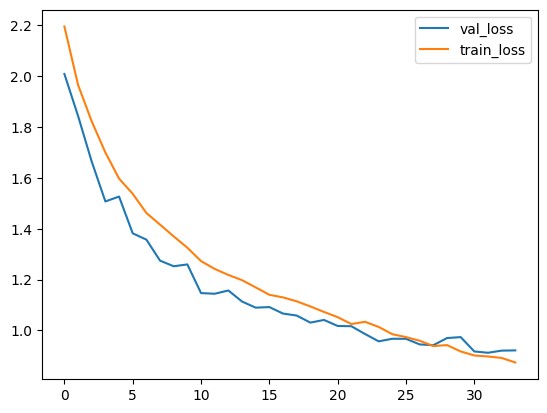

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataset.nat_vocab)
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 74.59%


<Axes: >

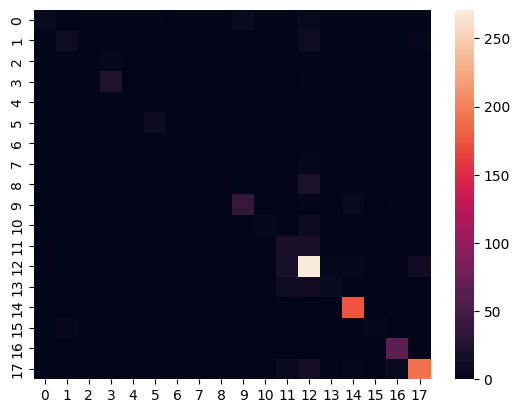

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

In [ ]:
students = ['Alueva', 'Sultonov', 'Mikhailenko']
students = [dataset.pad_features(dataset.create_idx_vec(x.lower()), dataset.max_seq_len) for x in students]
students = torch.stack(students).to(device)

preds = model.forward(students)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
_, preds = torch.topk(preds, 3)
preds

tensor([[ 1,  0, 12],
        [17,  1, 12],
        [17,  1, 16]], device='cuda:0')

In [ ]:
nat_list = [[dataset.nat_vocab.idx_to_token[z] for z in x] for x in preds.cpu().tolist()]
nat_list

[['czech', 'spanish', 'english'],
 ['russian', 'czech', 'english'],
 ['russian', 'czech', 'japanese']]

## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
paths = [r'C:\Users\user\Desktop\dz\DL\lab6\polarity\positive_reviews.txt', r'C:\Users\user\Desktop\dz\DL\lab6\polarity\negative_reviews.txt']

### data structures

In [ ]:
class Vocab:
    def __init__(self, data:list, spec_symb=True, start=0): # data - list of tokens
        self.create_tokens_set(data)

        self.idx_to_token = {i+start: v for i,v in enumerate(self.tokens) if v!='<PAD>'}

        self.token_to_idx = {v: i+start for i,v in enumerate(self.tokens) if v!='<PAD>'}

        if spec_symb and start>0:
            self.idx_to_token[0] = '<PAD>'
            self.token_to_idx['<PAD>'] = 0
            self.idx_to_token[1] = '<UNK>'
            self.token_to_idx['<UNK>'] = 1

    def create_tokens_set(self, data):
        self.tokens = list(set(data))

    def __len__(self):
        return len(self.token_to_idx)

In [ ]:
class MasterDF():
    def __init__(self, path: list): #path_0 - pos rev, path_1 - neg rev
        df = self.load_df(path)
        self.n_classes = len(df['class'].unique())

        self.stemmer = nltk.stem.SnowballStemmer('english')
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        df['rev'] = df['rev'].apply(self.preprocess_text)

        self.rev_max_len = len(max(df['rev'], key=len))
        df['rev'] = df['rev'].apply(self.pad_features)

        self.split_df(df)

        self.rev_vocab = Vocab(list(chain.from_iterable([[x for x in seq] for seq in self.train_df['rev'].tolist()])), spec_symb=True, start=2)
        self.val_df['rev'] = self.val_df['rev'].apply(self.fill_unk_tokens)
        self.test_df['rev'] = self.test_df['rev'].apply(self.fill_unk_tokens)

    def fill_unk_tokens(self, target: list):
        for i, token in enumerate(target):
            if token not in self.rev_vocab.token_to_idx.keys():
                target[i] = '<UNK>'
        return target

    def pad_features(self, target: list):
        diff = self.rev_max_len - len(target)
        for i in range(diff):
            target.append('<PAD>')
        return target

    def preprocess_text(self, text: str):
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = text.lower()
        text = nltk.tokenize.word_tokenize(text)
        text = [self.lemmatizer.lemmatize(word) for word in text if word not in self.stop_words]
        text = [self.stemmer.stem(word) for word in text]
        return text

    def split_df(self, df: pd.DataFrame):
        train_n = int(len(df) * 0.8)
        val_n = int(len(df) * 0.1)
        self.train_df = df.iloc[0:train_n]
        self.val_df = df.iloc[train_n: train_n+val_n]
        self.test_df = df.iloc[train_n+val_n:]

    def load_df(self, path: list):
        with open(paths[0]) as f:
            pos_lines = f.readlines()
            for i in range(len(pos_lines)):
                pos_lines[i] = (pos_lines[i], 0)
        with open(paths[1]) as f:
            neg_lines = f.readlines()
            for i in range(len(neg_lines)):
                neg_lines[i] = (neg_lines[i], 1)

        lines = pos_lines + neg_lines
        random.shuffle(lines)
        df = pd.DataFrame(lines, columns=['rev', 'class'])
        return df

In [ ]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab): #df to pass depend on category (train, val, test)
        self.df = df
        self.vocab = vocab

    def create_idx_vec(self, sent): #sent: list, list of tokens
        new_seq = torch.tensor([self.vocab.token_to_idx[item] for item in sent])
        return new_seq

    def __getitem__(self, idx: int):
        return self.create_idx_vec(self.df['rev'].iloc[idx]), self.df['class'].iloc[idx]

    def __len__(self):
        return len(self.df)

In [ ]:
class Transpose(torch.nn.Module):
    def __init__(self, dim0, dim1):
        super(Transpose, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        x = torch.transpose(x, self.dim0, self.dim1)
        return x

In [ ]:
class GetFeaturesFromRNN(torch.nn.Module):
    def forward(self, x):
        x, _ = x
        if len(x.shape) == 3:
            return x[:, -1, :]
        elif len(x.shape) == 2:
            return x[:, -1]

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, input_size, output_size): #input_size - len of rev dict
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Embedding(input_size+1, embedding_dim=200, padding_idx=0),
            nn.Dropout(0.25),
            Transpose(dim0=1, dim1=2),
            nn.Conv1d(in_channels=200, out_channels=50, kernel_size=3, stride=1, padding=0, dilation=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(2),
            Transpose(dim0=1, dim1=2),
            nn.LSTM(50, 200, num_layers=3, batch_first=True, dropout=0.5),
            GetFeaturesFromRNN()
        )
        self.classificator = nn.Sequential(
            nn.Linear(in_features=200, out_features=output_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.features.forward(x)
        x = torch.flatten(x, 1)
        x = self.classificator.forward(x)
        return x

### proccessing

In [ ]:
BATCH_SIZE = 100
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
paths = [r'C:\Users\user\Desktop\dz\DL\lab6\polarity\positive_reviews.txt', r'C:\Users\user\Desktop\dz\DL\lab6\polarity\negative_reviews.txt']

In [ ]:
mdf = MasterDF(paths)

C:\Users\user\AppData\Local\Temp\ipykernel_10116\2273314123.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_df['rev'] = self.val_df['rev'].apply(self.fill_unk_tokens)
C:\Users\user\AppData\Local\Temp\ipykernel_10116\2273314123.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_df['rev'] = self.test_df['rev'].apply(self.fill_unk_tokens)


In [ ]:
train_dataset, val_dataset, test_dataset = ReviewDataset(mdf.train_df, mdf.rev_vocab), ReviewDataset(mdf.val_df, mdf.rev_vocab), ReviewDataset(mdf.test_df, mdf.rev_vocab)

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [ ]:
in_size = len(mdf.rev_vocab)
out_size = mdf.n_classes
print(f'in = {in_size}, out = {out_size}')

in = 11149, out = 2


In [ ]:
model = Model(in_size, out_size).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 3105252


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.001, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
for epoch in range(EPOCH):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'early stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


counter = 1
counter = 2
counter = 3
counter = 4
counter = 5
counter = 6
counter = 7
counter = 8
counter = 9
counter = 10
early stop at epoch №15


<Axes: >

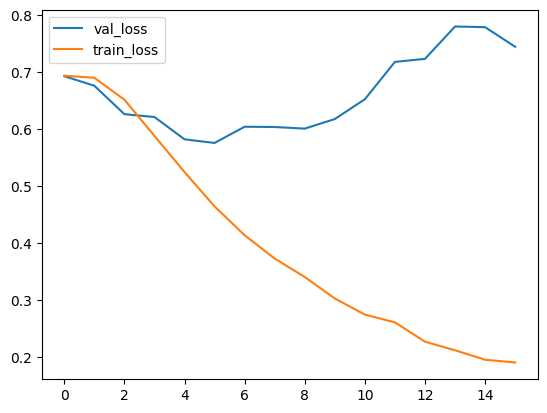

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [0, 1])
torch.cuda.empty_cache() if device == 'cuda' else None

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 74.13%


<Axes: >

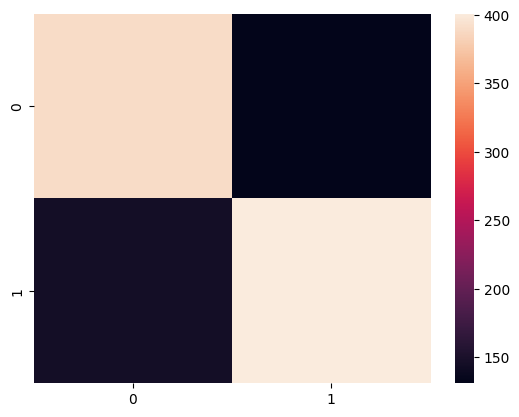

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])